In [ ]:
from google.colab import files
my = files.upload()

Saving FIFA_test.csv to FIFA_test.csv
Saving FIFA_train.csv to FIFA_train.csv
Saving submission.csv to submission.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

train_df = pd.read_csv('/content/FIFA_train.csv')
test_df = pd.read_csv('/content/FIFA_test.csv')

In [ ]:
train_df.drop(['id', 'name'], axis = 1, inplace = True)
test_df.drop(['id', 'name'], axis = 1, inplace = True)

In [ ]:
def func_con(string:object) -> int:
    """계약 연도만 추출하여 int로 반환"""
    string = string[-4:]
    return int(string)

In [ ]:
train_df['contract_until'] = train_df['contract_until'].apply(func_con)
test_df['contract_until'] = test_df['contract_until'].apply(func_con)

In [ ]:
train_df.describe(include = 'all')

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932,8932.000000,8932,8932,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
unique,NaN,5,NaN,4,2,NaN,NaN,NaN,NaN,NaN
top,NaN,europe,NaN,MF,right,NaN,NaN,NaN,NaN,NaN
freq,NaN,5322,NaN,3428,6837,NaN,NaN,NaN,NaN,NaN
mean,25.209136,NaN,2020.194357,NaN,NaN,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4.635515,NaN,1.266901,NaN,NaN,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,16.000000,NaN,2018.000000,NaN,NaN,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,21.000000,NaN,2019.000000,NaN,NaN,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,25.000000,NaN,2020.000000,NaN,NaN,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,28.000000,NaN,2021.000000,NaN,NaN,1.000000,72.000000,76.000000,3.000000,2.600000e+06


In [ ]:
#더미화
train_df = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = train_df)
test_df = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = test_df)

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df["log_value"] = np.log1p(train_df["value"])
train_df["contract_until"] = train_df["contract_until"].apply(lambda x: x-2018)
test_df["contract_until"] = test_df["contract_until"].apply(lambda x: x-2018)

x = train_df.drop(['value','log_value'], axis = 1)
y = train_df['log_value']


In [ ]:
from sklearn.model_selection import train_test_split
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 33)

In [ ]:
# 데이터 스케일링 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns = x_test.columns)

In [ ]:
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns = test_df.columns)

In [ ]:
#y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
#y_test = scaler.fit_transform(y_test.values.reshape(-1,1))

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6252, 17), (2680, 17), (6252,), (2680,))

In [ ]:
!pip install bayesian-optimization

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import *
from sklearn.metrics import *
from bayes_opt import BayesianOptimization

pbounds = { 'learning_rate': (0.0001, 0.4),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5, 1),  
            'colsample_bytree': (0.5, 1),   
            'gamma': (0, 5)}

def xgb_func(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample_bytree,   
        'gamma': gamma,
        'n_jobs' : -1,
        'random_state' : 333
    }
    
    xgb = XGBRegressor(**params) #**는 파라미터 변수 명까지 딕셔너리로 전달
    
    kf = KFold(n_splits = 4 , shuffle=True, random_state=333)

    score = cross_val_score(xgb, x_train, y_train, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)


In [ ]:
optimizer = BayesianOptimization(f = xgb_func, pbounds = pbounds, random_state=333)
optimizer.maximize(init_points = 10, n_iter = 190)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.92     | 0.7716    | 3.645     | 0.006851  | 5.312     | 387.7     | 0.5242    |
| 2         | -0.01121  | 0.5523    | 0.4872    | 0.09824   | 9.114     | 68.02     | 0.5302    |
| 3         | -0.01198  | 0.6194    | 1.018     | 0.0699    | 5.907     | 965.3     | 0.7335    |
| 4         | -0.02956  | 0.98      | 4.999     | 0.2906    | 6.39      | 143.9     | 0.5527    |
| 5         | -0.01319  | 0.5211    | 1.221     | 0.0287    | 9.969     | 218.9     | 0.9412    |
| 6         | -0.01297  | 0.6226    | 0.5772    | 0.2369    | 7.958     | 147.3     | 0.5593    |
| 7         | -0.02     | 0.5019    | 2.847     | 0.1928    | 5.388     | 282.8     | 0.6739    |
| 8         | -0.03154  | 0.9604    | 4.916     | 0.3906    | 3.299     | 830.5     | 0.9333    |
| 9         | -0.019

In [ ]:
optimizer.max

{'target': -0.0055692287026295985,
 'params': {'colsample_bytree': 0.5,
  'gamma': 0.0,
  'learning_rate': 0.4,
  'max_depth': 3.0,
  'n_estimators': 477.8330647221409,
  'subsample': 1.0}}

In [ ]:
params = optimizer.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))

xgb = XGBRegressor(random_state = 333, **params, eval_metric = 'rmse')
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=478, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=333, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

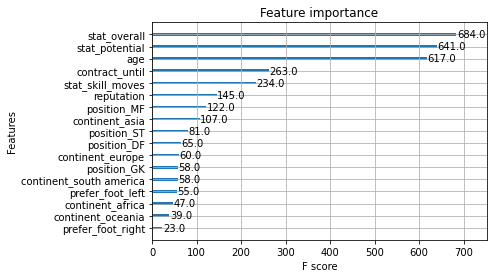

In [ ]:
import xgboost

xgboost.plot_importance(xgb)

In [ ]:
xgb.score(x_test, y_test)
#r2 결정계수

0.9971040637785991

In [ ]:
pred = np.expm1(xgb.predict(test_df))

#제출 파일

In [ ]:
submission = pd.read_csv('submission.csv', encoding = 'utf-8')

In [ ]:
submission['value'] = pred

In [ ]:
submission.to_csv('fifa_sub.csv', index = False)